In [1]:
access_token = ""
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn import linear_model
import requests

In [2]:
def getReqDate(d):
    
    start = pd.to_datetime(d)
    sYear = str(start.year)
    sMonth = ""
    sDay = ""
    
    if(start.month <10):
        sMonth = "0"+ str(start.month)
    else:
        sMonth = str(start.month)
    
    if(start.day <10):
        sDay = "0"+ str(start.day)
    else:
        sDay = str(start.day)
    
    output = sYear+sMonth+sDay+"T000000"
    return output

In [3]:
def getHashRateData(start,end,timeFrame):
    access_token = ""
    headers = {'Authorization': 'Bearer ' + access_token}
    fromDate = getReqDate(start)
    toDate = getReqDate(end)
    url = "https://api.cryptoquant.com/v1/btc/network-data/hashrate?window="+timeFrame+"&from="+fromDate+"&to="+toDate+"&limit=100000"
    temp = pd.DataFrame(requests.get(url, headers=headers).json()['result']['data'])
    temp.sort_values(by = 'date',inplace=True)
    temp.index = pd.to_datetime(temp.date)
    check = pd.to_datetime(temp.index[0])
    check1 = pd.to_datetime(start)
    if check.year != check1.year or check.month != check1.month or check.day != check1.day:
        newEnd = check
        #print(newEnd)
        newDF = pd.concat([getData(start,newEnd,timeFrame,pair), temp])
        dupIndex = newDF.index.duplicated(keep="first")
        newDF = newDF[~dupIndex]
        newDF.sort_index(inplace=True)

        return newDF
    else:
        return temp


In [30]:
def getMaxLoan(timeFrame, clientHashRate, interestRate, btcPrice, df):
    hashRates = []
    days = []
    i = 0
    for row in df.iterrows():
        hashRates.append(row[1].hashrate)
        days.append(i)
        i += 1
        
    plt.plot(days, hashRates, label = 'Historical Hashrate')
    
    reg = linear_model.LinearRegression()
    reg.fit(np.array(days).reshape(-1, 1), hashRates)
    
    lastDay = max(days)
    for j in range(timeFrame):
        days.append(lastDay+j+1)
    
    predictedHashRate = reg.predict(np.array(days).reshape(-1, 1))
    plt.plot(days, predictedHashRate, label = 'Predicted Hashrate')
    plt.ylabel("Hashrate (GH/s)")
    plt.xlabel("Days since " + str(df.head(1).date.tolist()[0]))
    plt.legend()
    plt.show()
    
    hashOverLoanPeriod = np.mean(predictedHashRate[-timeFrame:])
    btcBlockTimeMin = 10
    btcOverLoanPeriod = timeFrame*24*60/10
    
    clientHashrateDominance = (clientHashRate/hashOverLoanPeriod)
    
    btcMinedOverLoan = clientHashrateDominance*btcOverLoanPeriod
    
    usdOverLoanPeriod = btcMinedOverLoan * btcPrice 
    
    maxLoan = usdOverLoanPeriod/(1 + interestRate)
    
    print("----------------LOAN DETAILS----------------")
    print("Loan Period: " + str(timeFrame) + " days" + " / Interest Rate: " + ("{:,.2f}%".format(interestRate*100)))
    print("Expected Average Hashrate: " + ("{:,.0f}".format(hashOverLoanPeriod)) + " GH/s")
    print("Expected Client Hashrate Dominance: " + ("{:,.2f}%".format(clientHashrateDominance*100)))
    print("Expected Client BTC Returns: " + ("{:,.4f}".format(btcMinedOverLoan)))
    print("Expected Client USD Returns: " + ("${:,.2f}".format(usdOverLoanPeriod)))
    print("Maximum Loan: " + ("${:,.2f}".format(maxLoan)))
    print("--------Genesis Expected Profit--------")
    print(("${:,.2f}".format(usdOverLoanPeriod - maxLoan)))

In [31]:
#Format: YYYY-MM-DD
start = "2018-01-01"
end = "2022-08-03"
#Format: {"min","hour","day"}
timeFrame = "day"

In [32]:
hashs = getHashRateData(start,end,timeFrame)

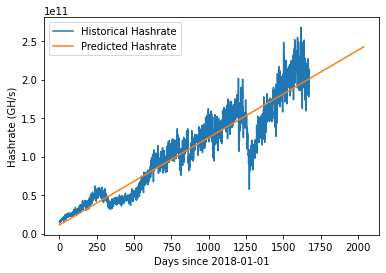

----------------LOAN DETAILS----------------
Loan Period: 365 days / Interest Rate: 8.00%
Expected Average Hashrate: 221,912,227,496 GH/s
Expected Client Hashrate Dominance: 1.89%
Expected Client BTC Returns: 994.7717
Expected Client USD Returns: $21,884,977.02
Maximum Loan: $20,263,867.61
--------Genesis Expected Profit--------
$1,621,109.41


In [33]:
#Inputs: days of loan period, client hashrate, interest rate, btc price, and historical hashrate df
getMaxLoan(365, 4.2e9, 0.08, 22000, hashs)

In [28]:
6*24*365*6.25

328500.0